# RNN TIMIT demo

This notebook is an extension of the previous one on MLP. To find more details, read that one first.

*This is still work in progress!*

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='3'
#os.environ['KERAS_BACKEND']='tensorflow'

In [2]:
import numpy as np
from random import shuffle
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.wrappers import *
from keras.optimizers import *
from IPython.display import clear_output
import time
import sys
from tqdm import *

sys.path.append('../python')

from data import Corpus, History

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN not available)


In [3]:
train=Corpus('../data/TIMIT_train.hdf5',load_normalized=True)
dev=Corpus('../data/TIMIT_dev.hdf5',load_normalized=True)
test=Corpus('../data/TIMIT_test.hdf5',load_normalized=True)

In [4]:
maxlen=max([train.getMaxLen(),dev.getMaxLen(),test.getMaxLen()])
print maxlen

777


In [5]:
tr_in,tr_out_dec=train.get()
dev_in,dev_out_dec=dev.get()
tst_in,tst_out_dec=test.get()
for u in range(tr_in.shape[0]):
    tr_in[u]=tr_in[u][:,:26]
for u in range(dev_in.shape[0]):    
    dev_in[u]=dev_in[u][:,:26]
for u in range(tst_in.shape[0]):
    tst_in[u]=tst_in[u][:,:26]

In [6]:
input_dim=tr_in[0].shape[1]
output_dim=61
hidden_num=140
epoch_num=50

def dec2onehot(dec):
    ret=[]
    for u in dec:
        assert np.all(u<output_dim)
        num=u.shape[0]
        r=np.zeros((num,output_dim))
        r[range(0,num),u]=1
        ret.append(r)
    return np.array(ret)

tr_out=dec2onehot(tr_out_dec)
dev_out=dec2onehot(dev_out_dec)
tst_out=dec2onehot(tst_out_dec)

## Model definition



In [7]:
model = Sequential()

#model.add(LSTM_w_peepholes(input_dim=input_dim,output_dim=hidden_num,return_sequences=True))
model.add(LSTM(input_dim=input_dim,output_dim=hidden_num,return_sequences=True))
model.add(TimeDistributed(Dense(output_dim=output_dim)))
model.add(Activation('softmax'))

#optimizer = SGD(lr=4e-3, momentum=0.9, nesterov=False)
#optimizer= Adam(lr=0.0001)
optimizer=RMSprop(lr=4e-3)
loss='categorical_crossentropy'
metrics=['accuracy']
          
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [8]:
tr_hist=History('Train')
dev_hist=History('Dev')
tst_hist=History('Test')

tr_it=range(tr_in.shape[0])

for e in range(epoch_num):
    
    print 'Epoch #{}/{}'.format(e+1,epoch_num)
    sys.stdout.flush()
    
    shuffle(tr_it)
    for u in tqdm(tr_it):
        l,a=model.train_on_batch(np.array([tr_in[u]]),np.array([tr_out[u]]))
        tr_hist.r.addLA(l,a,tr_out[u].shape[0])        
    clear_output()    
    tr_hist.log()
    
    for u in range(dev_in.shape[0]):
        l,a=model.test_on_batch(np.array([dev_in[u]]),np.array([dev_out[u]]))
        dev_hist.r.addLA(l,a,dev_out[u].shape[0])
    dev_hist.log()
    
    
    for u in range(tst_in.shape[0]):
        l,a=model.test_on_batch(np.array([tst_in[u]]),np.array([tst_out[u]]))
        tst_hist.r.addLA(l,a,tst_out[u].shape[0])
    tst_hist.log()            
    
print 'Done!'
    

Train loss: 1.03277289867
Train PER: 32.014815%
Dev loss: 1.24962925911
Dev PER: 36.585923%
Test loss: 1.27113211155
Test PER: 37.309000%
Done!


<IPython.core.display.Javascript object>


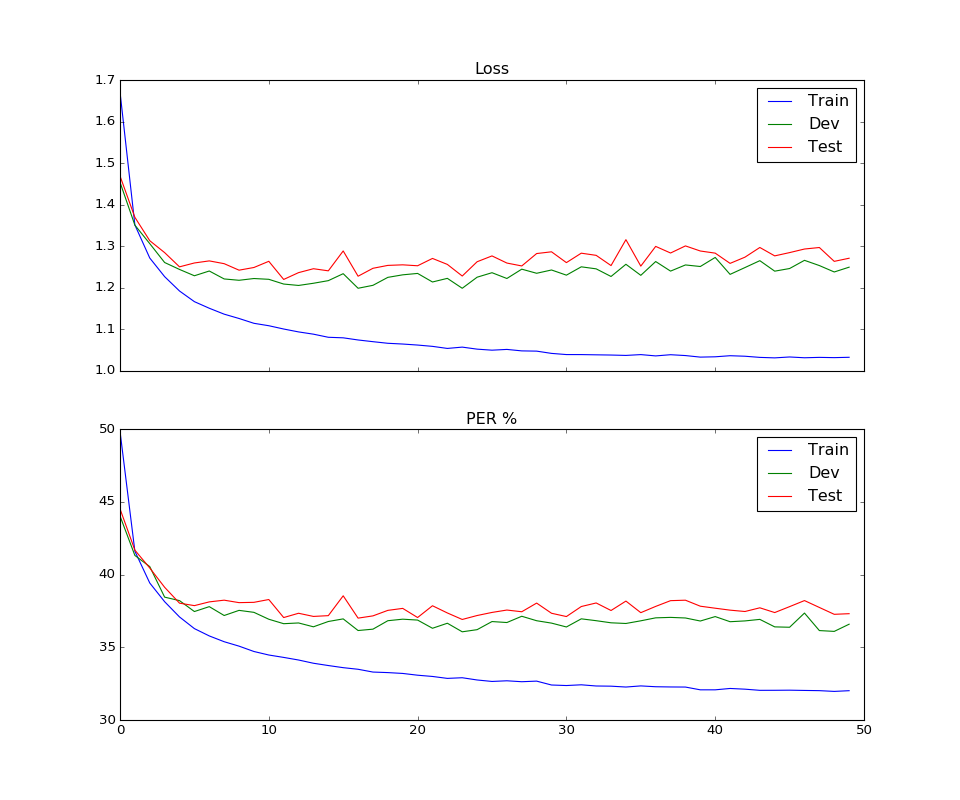

In [9]:
import matplotlib.pyplot as P
%matplotlib notebook

fig,ax=P.subplots(2,sharex=True,figsize=(12,10))

ax[0].set_title('Loss')
ax[0].plot(tr_hist.loss,label='Train')
ax[0].plot(dev_hist.loss,label='Dev')
ax[0].plot(tst_hist.loss,label='Test')
ax[0].legend()

ax[1].set_title('PER %')
ax[1].plot(100*(1-np.array(tr_hist.acc)),label='Train')
ax[1].plot(100*(1-np.array(dev_hist.acc)),label='Dev')
ax[1].plot(100*(1-np.array(tst_hist.acc)),label='Test')
ax[1].legend()

In [10]:
print 'Min test PER: {:%}'.format(1-np.max(tst_hist.acc))
print 'Min dev PER epoch: #{}'.format((np.argmax(dev_hist.acc)+1))
print 'Test PER on min dev: {:%}'.format(1-tst_hist.acc[np.argmax(dev_hist.acc)])

Min test PER: 36.911894%
Min dev PER epoch: #24
Test PER on min dev: 36.911894%
